Using device: cpu
Starting PINN training for 3D Burgers' equation...


Training PINN: 100%|██████████| 3000/3000 [09:05<00:00,  5.50it/s, loss=21.720253, pde_loss=0.370133, ic_loss=0.419142, bc_loss=0.019651]


Generating u-velocity centerline plots...
Evaluating at t = 0.0
Evaluating at t = 0.2
Evaluating at t = 0.4
Evaluating at t = 0.8
Evaluating at t = 1.2
Evaluating at t = 1.6


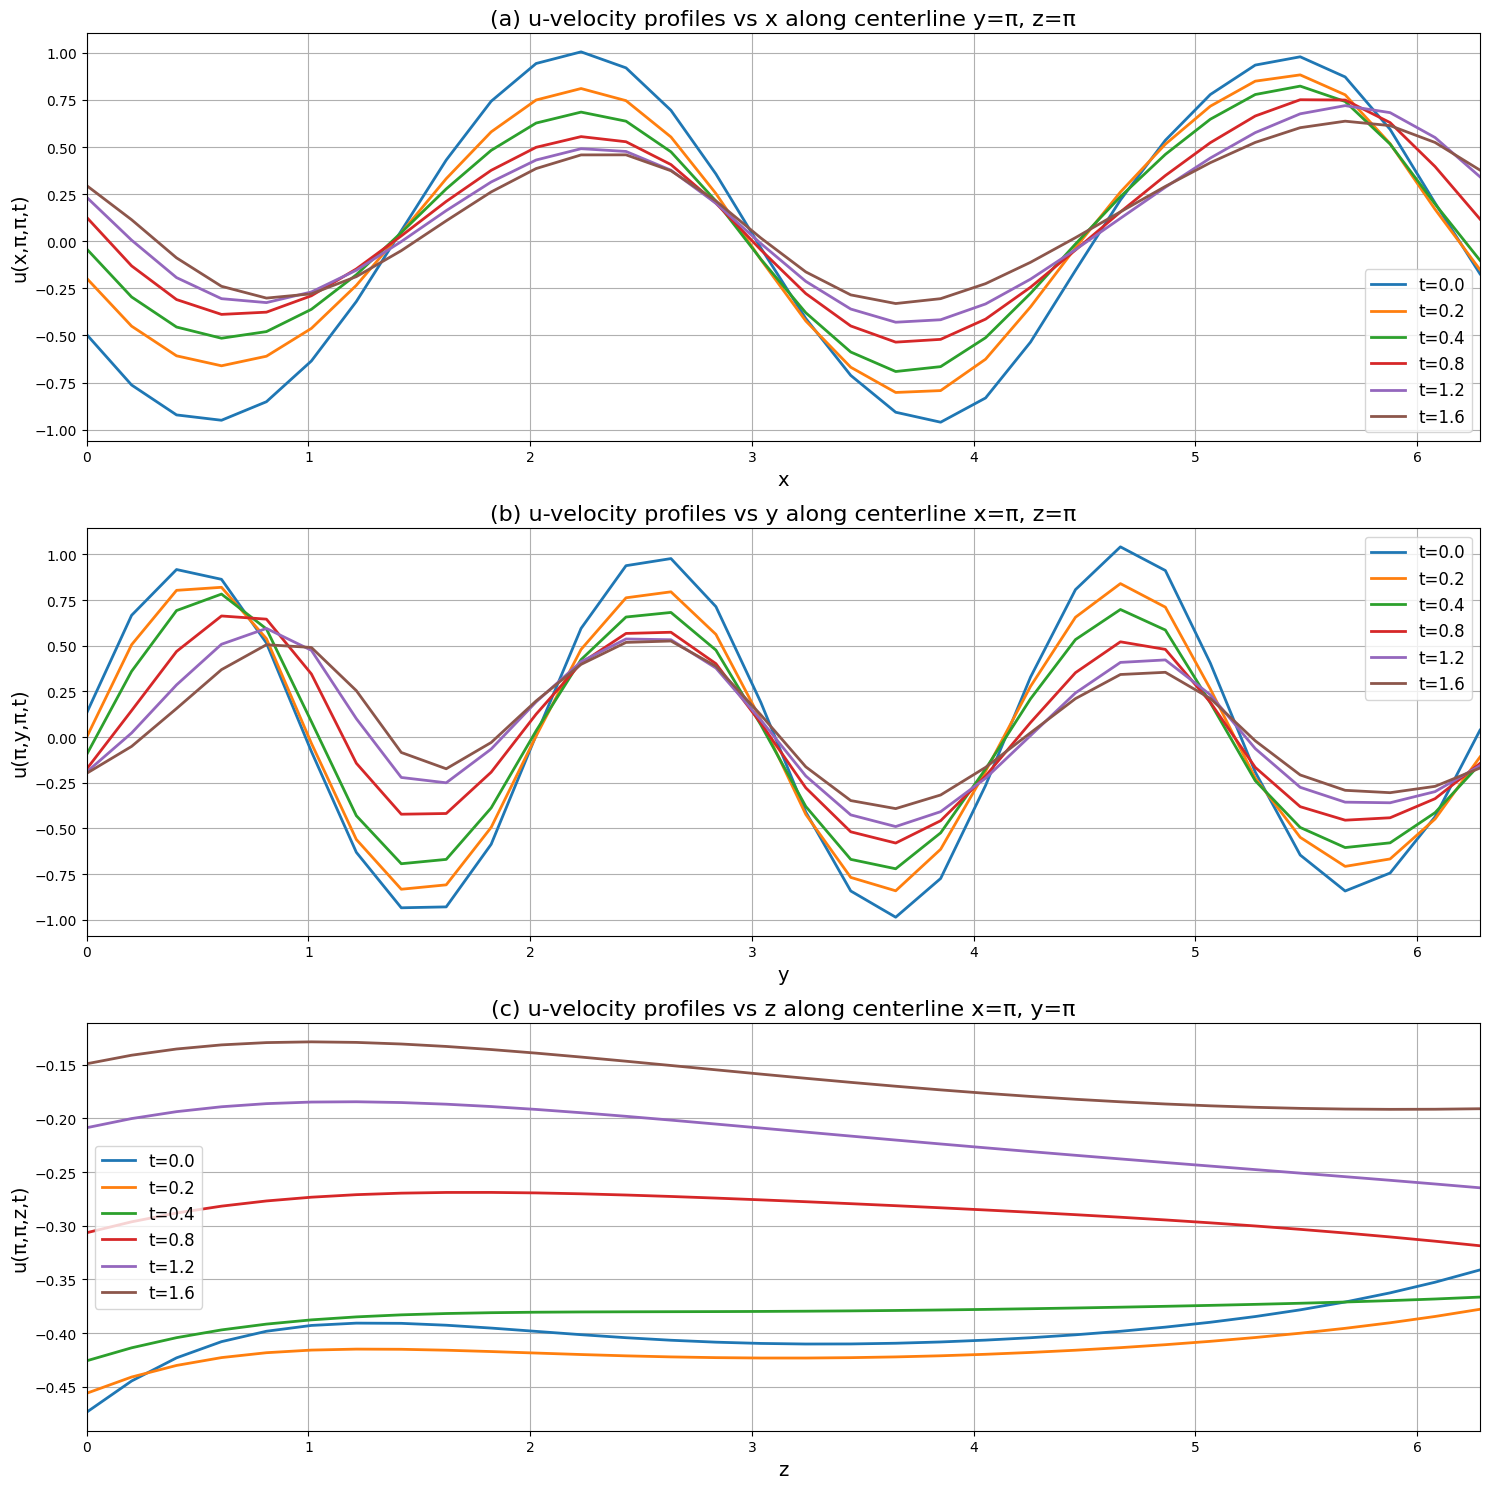

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
L = 2*np.pi  # Domain length in each direction
nx, ny, nz = 32, 32, 32  # Grid size
Re = 100.0  # Reynolds number
tmax = 1.6  # Maximum simulation time
nu = 1.0/Re  # Kinematic viscosity
time_points = [0.0, 0.2, 0.4, 0.8, 1.2, 1.6]  # Time points for visualization

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class BurgersPINN(nn.Module):
    def __init__(self, hidden_layers=4, neurons=40):
        super(BurgersPINN, self).__init__()

        # Neural network for approximating the solution u(x,y,z,t)
        layers = []
        layers.append(nn.Linear(4, neurons))  # Input: (x, y, z, t)
        layers.append(nn.Tanh())

        for _ in range(hidden_layers):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(neurons, 3))  # Output: u, v, w velocity components

        self.net = nn.Sequential(*layers)

        # Initialize weights using Xavier initialization
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, y, z, t):
        # Combine inputs into a single tensor
        inputs = torch.cat([x, y, z, t], dim=1)
        outputs = self.net(inputs)
        return outputs

    def velocity_components(self, x, y, z, t):
        outputs = self.forward(x, y, z, t)
        u = outputs[:, 0:1]  # x-velocity component
        v = outputs[:, 1:2]  # y-velocity component
        w = outputs[:, 2:3]  # z-velocity component
        return u, v, w

    def pde_residual(self, x, y, z, t):
        # Make inputs require gradients
        x.requires_grad_(True)
        y.requires_grad_(True)
        z.requires_grad_(True)
        t.requires_grad_(True)

        # Get velocity components
        u, v, w = self.velocity_components(x, y, z, t)

        # Calculate derivatives using autograd
        # First derivatives wrt time
        du_dt = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        dv_dt = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        dw_dt = torch.autograd.grad(w, t, grad_outputs=torch.ones_like(w), create_graph=True)[0]

        # First derivatives wrt space
        du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        du_dy = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        du_dz = torch.autograd.grad(u, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        dv_dx = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        dv_dy = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        dv_dz = torch.autograd.grad(v, z, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        dw_dx = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(w), create_graph=True)[0]
        dw_dy = torch.autograd.grad(w, y, grad_outputs=torch.ones_like(w), create_graph=True)[0]
        dw_dz = torch.autograd.grad(w, z, grad_outputs=torch.ones_like(w), create_graph=True)[0]

        # Second derivatives for viscous terms
        d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]
        d2u_dy2 = torch.autograd.grad(du_dy, y, grad_outputs=torch.ones_like(du_dy), create_graph=True)[0]
        d2u_dz2 = torch.autograd.grad(du_dz, z, grad_outputs=torch.ones_like(du_dz), create_graph=True)[0]

        d2v_dx2 = torch.autograd.grad(dv_dx, x, grad_outputs=torch.ones_like(dv_dx), create_graph=True)[0]
        d2v_dy2 = torch.autograd.grad(dv_dy, y, grad_outputs=torch.ones_like(dv_dy), create_graph=True)[0]
        d2v_dz2 = torch.autograd.grad(dv_dz, z, grad_outputs=torch.ones_like(dv_dz), create_graph=True)[0]

        d2w_dx2 = torch.autograd.grad(dw_dx, x, grad_outputs=torch.ones_like(dw_dx), create_graph=True)[0]
        d2w_dy2 = torch.autograd.grad(dw_dy, y, grad_outputs=torch.ones_like(dw_dy), create_graph=True)[0]
        d2w_dz2 = torch.autograd.grad(dw_dz, z, grad_outputs=torch.ones_like(dw_dz), create_graph=True)[0]

        # Compute PDE residuals (3D Burgers' equations)
        f_u = du_dt + u * du_dx + v * du_dy + w * du_dz - nu * (d2u_dx2 + d2u_dy2 + d2u_dz2)
        f_v = dv_dt + u * dv_dx + v * dv_dy + w * dv_dz - nu * (d2v_dx2 + d2v_dy2 + d2v_dz2)
        f_w = dw_dt + u * dw_dx + v * dw_dy + w * dw_dz - nu * (d2w_dx2 + d2w_dy2 + d2w_dz2)

        return f_u, f_v, f_w

    def initial_condition_residual(self, x, y, z):
        t = torch.zeros_like(x)

        # Get predicted velocity components at t=0
        u_pred, v_pred, w_pred = self.velocity_components(x, y, z, t)

        # Define initial condition: u(x,0) = sin(2x + 3y)i + cos(3x + 2z)j + sin(2y + x)k
        u_true = torch.sin(2*x + 3*y)
        v_true = torch.cos(3*x + 2*z)
        w_true = torch.sin(2*y + x)

        # Compute residuals
        r_u = u_pred - u_true
        r_v = v_pred - v_true
        r_w = w_pred - w_true

        return r_u, r_v, r_w

    def periodic_boundary_residual(self, x, y, z, t):
        # Create points at the boundaries to enforce periodicity
        # For x-direction
        x_left = torch.zeros_like(x)
        x_right = torch.ones_like(x) * L

        # For y-direction
        y_left = torch.zeros_like(y)
        y_right = torch.ones_like(y) * L

        # For z-direction
        z_left = torch.zeros_like(z)
        z_right = torch.ones_like(z) * L

        # Get velocity at opposite boundaries
        u_x0, v_x0, w_x0 = self.velocity_components(x_left, y, z, t)
        u_xL, v_xL, w_xL = self.velocity_components(x_right, y, z, t)

        u_y0, v_y0, w_y0 = self.velocity_components(x, y_left, z, t)
        u_yL, v_yL, w_yL = self.velocity_components(x, y_right, z, t)

        u_z0, v_z0, w_z0 = self.velocity_components(x, y, z_left, t)
        u_zL, v_zL, w_zL = self.velocity_components(x, y, z_right, t)

        # Residuals for periodic boundary conditions
        r_u_x = u_x0 - u_xL
        r_v_x = v_x0 - v_xL
        r_w_x = w_x0 - w_xL

        r_u_y = u_y0 - u_yL
        r_v_y = v_y0 - v_yL
        r_w_y = w_y0 - w_yL

        r_u_z = u_z0 - u_zL
        r_v_z = v_z0 - v_zL
        r_w_z = w_z0 - w_zL

        return (r_u_x, r_v_x, r_w_x,
                r_u_y, r_v_y, r_w_y,
                r_u_z, r_v_z, r_w_z)

def train_pinn():
    print("Starting PINN training for 3D Burgers' equation...")

    # Create model
    model = BurgersPINN(hidden_layers=4, neurons=40).to(device)
    model = model.float()  # Ensure all model parameters are float32

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, verbose=True)

    # Training parameters - reduced for faster execution
    epochs = 3000
    n_points_pde = 2000  # Number of collocation points for PDE
    n_points_ic = 1000   # Number of points for initial condition
    n_points_bc = 500    # Number of points for boundary conditions

    # Generate collocation points - ensure they are all float32 type
    # For the interior PDE points
    x_collocation = torch.rand(n_points_pde, 1, device=device, dtype=torch.float32) * L
    y_collocation = torch.rand(n_points_pde, 1, device=device, dtype=torch.float32) * L
    z_collocation = torch.rand(n_points_pde, 1, device=device, dtype=torch.float32) * L
    t_collocation = torch.rand(n_points_pde, 1, device=device, dtype=torch.float32) * tmax

    # For the initial condition
    x_ic = torch.rand(n_points_ic, 1, device=device, dtype=torch.float32) * L
    y_ic = torch.rand(n_points_ic, 1, device=device, dtype=torch.float32) * L
    z_ic = torch.rand(n_points_ic, 1, device=device, dtype=torch.float32) * L

    # For periodic boundary conditions
    x_bc = torch.rand(n_points_bc, 1, device=device, dtype=torch.float32) * L
    y_bc = torch.rand(n_points_bc, 1, device=device, dtype=torch.float32) * L
    z_bc = torch.rand(n_points_bc, 1, device=device, dtype=torch.float32) * L
    t_bc = torch.rand(n_points_bc, 1, device=device, dtype=torch.float32) * tmax

    # Loss weights
    w_pde = 1.0
    w_ic = 50.0   # Higher weight for initial conditions
    w_bc = 20.0   # Increased weight for boundary conditions to enforce periodicity

    # Training loop
    pbar = tqdm(range(epochs), desc="Training PINN")
    loss_history = []
    ic_loss_history = []
    pde_loss_history = []
    bc_loss_history = []
    best_loss = float('inf')
    best_model_state = None

    for epoch in pbar:
        model.train()
        optimizer.zero_grad()

        # PDE residuals
        f_u, f_v, f_w = model.pde_residual(x_collocation, y_collocation, z_collocation, t_collocation)
        pde_loss = torch.mean(f_u**2 + f_v**2 + f_w**2)

        # Initial condition residuals
        r_u_ic, r_v_ic, r_w_ic = model.initial_condition_residual(x_ic, y_ic, z_ic)
        ic_loss = torch.mean(r_u_ic**2 + r_v_ic**2 + r_w_ic**2)

        # Periodic boundary condition residuals
        bc_residuals = model.periodic_boundary_residual(x_bc, y_bc, z_bc, t_bc)
        # Sum all the squared boundary condition residuals
        bc_loss = torch.mean(torch.cat([res**2 for res in bc_residuals]))

        # Total loss
        loss = w_pde * pde_loss + w_ic * ic_loss + w_bc * bc_loss

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Save loss history
        loss_val = loss.item()
        loss_history.append(loss_val)
        pde_loss_history.append(pde_loss.item())
        ic_loss_history.append(ic_loss.item())
        bc_loss_history.append(bc_loss.item())

        # Save best model
        if loss_val < best_loss:
            best_loss = loss_val
            best_model_state = model.state_dict().copy()

        # Update scheduler
        scheduler.step(loss_val)

        # Update progress bar
        if epoch % 50 == 0:
            pbar.set_postfix({
                "loss": f"{loss_val:.6f}",
                "pde_loss": f"{pde_loss.item():.6f}",
                "ic_loss": f"{ic_loss.item():.6f}",
                "bc_loss": f"{bc_loss.item():.6f}"
            })

    # Load best model
    model.load_state_dict(best_model_state)
    model.eval()

    return model, loss_history, pde_loss_history, ic_loss_history, bc_loss_history

def plot_u_velocity_centerlines(model):
    """Plot u-velocity profiles along centerlines"""
    print("Generating u-velocity centerline plots...")

    # Create mesh grid for evaluation
    x = np.linspace(0, L, nx)
    y = np.linspace(0, L, ny)
    z = np.linspace(0, L, nz)

    # Define centerline indices
    mid_y = ny // 2
    mid_z = nz // 2
    mid_x = nx // 2

    # Store results for u velocity
    u_results = {}

    # Convert model to float32 for consistency
    model = model.float()

    # Evaluate at different time points
    for t_val in time_points:
        print(f"Evaluating at t = {t_val}")

        # Initialize array to store u velocity
        u_vals = np.zeros((nx, ny, nz))

        with torch.no_grad():
            # For u(x, π, π, t) - varying x
            for i in range(nx):
                x_tensor = torch.tensor([[x[i]]], dtype=torch.float32, device=device)
                y_tensor = torch.tensor([[y[mid_y]]], dtype=torch.float32, device=device)
                z_tensor = torch.tensor([[z[mid_z]]], dtype=torch.float32, device=device)
                t_tensor = torch.tensor([[t_val]], dtype=torch.float32, device=device)

                u_pred, _, _ = model.velocity_components(x_tensor, y_tensor, z_tensor, t_tensor)
                u_vals[i, mid_y, mid_z] = u_pred.cpu().numpy().item()

            # For u(π, y, π, t) - varying y
            for j in range(ny):
                x_tensor = torch.tensor([[x[mid_x]]], dtype=torch.float32, device=device)
                y_tensor = torch.tensor([[y[j]]], dtype=torch.float32, device=device)
                z_tensor = torch.tensor([[z[mid_z]]], dtype=torch.float32, device=device)
                t_tensor = torch.tensor([[t_val]], dtype=torch.float32, device=device)

                u_pred, _, _ = model.velocity_components(x_tensor, y_tensor, z_tensor, t_tensor)
                u_vals[mid_x, j, mid_z] = u_pred.cpu().numpy().item()

            # For u(π, π, z, t) - varying z
            for k in range(nz):
                x_tensor = torch.tensor([[x[mid_x]]], dtype=torch.float32, device=device)
                y_tensor = torch.tensor([[y[mid_y]]], dtype=torch.float32, device=device)
                z_tensor = torch.tensor([[z[k]]], dtype=torch.float32, device=device)
                t_tensor = torch.tensor([[t_val]], dtype=torch.float32, device=device)

                u_pred, _, _ = model.velocity_components(x_tensor, y_tensor, z_tensor, t_tensor)
                u_vals[mid_x, mid_y, k] = u_pred.cpu().numpy().item()

        u_results[t_val] = u_vals

    # Plot u velocity component along centerlines
    plt.figure(figsize=(15, 15))

    # (a) u(x, π, π, t) - varying x
    plt.subplot(3, 1, 1)
    for t_val in time_points:
        u_centerline = u_results[t_val][:, mid_y, mid_z]
        plt.plot(x, u_centerline, '-', linewidth=2, label=f't={t_val}')

    plt.xlabel('x', fontsize=14)
    plt.ylabel('u(x,π,π,t)', fontsize=14)
    plt.title('(a) u-velocity profiles vs x along centerline y=π, z=π', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.xlim(0, L)

    # (b) u(π, y, π, t) - varying y
    plt.subplot(3, 1, 2)
    for t_val in time_points:
        u_centerline = u_results[t_val][mid_x, :, mid_z]
        plt.plot(y, u_centerline, '-', linewidth=2, label=f't={t_val}')

    plt.xlabel('y', fontsize=14)
    plt.ylabel('u(π,y,π,t)', fontsize=14)
    plt.title('(b) u-velocity profiles vs y along centerline x=π, z=π', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.xlim(0, L)

    # (c) u(π, π, z, t) - varying z
    plt.subplot(3, 1, 3)
    for t_val in time_points:
        u_centerline = u_results[t_val][mid_x, mid_y, :]
        plt.plot(z, u_centerline, '-', linewidth=2, label=f't={t_val}')

    plt.xlabel('z', fontsize=14)
    plt.ylabel('u(π,π,z,t)', fontsize=14)
    plt.title('(c) u-velocity profiles vs z along centerline x=π, y=π', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.xlim(0, L)

    plt.tight_layout()
    plt.savefig("u_velocity_centerlines.png", dpi=300, bbox_inches="tight")
    plt.show()

# Main function to run the code
def main():
    # Train the model - this is computationally expensive
    # If you have a pre-trained model, you can skip this step
    model, loss_history, pde_loss_history, ic_loss_history, bc_loss_history = train_pinn()

    # Plot the u-velocity profiles along centerlines
    plot_u_velocity_centerlines(model)

if __name__ == "__main__":
    main()